# Graphentheorie WS 20/21

## Netzwerkanalyse Aufgabe

In [1]:
%config IPCompleter.use_jedi = False

In [2]:
import pandas as pd
import glob
from os import listdir

from collections import Counter
from itertools import combinations
from functools import reduce
import networkx as nx

### Generierung eines Graphen

In [3]:
def make_graph(pairs):
    #print(pairs)
    
    weighted_edges = []
    for pair, weight in Counter([pair for pair in pairs]).items():
        weighted_edges.append(str(pair[0]) + "\t" + str(pair[1]) + "\t" + str(weight))
    graph = nx.parse_edgelist(weighted_edges, delimiter="\t", data=(('weight', float),) )
    
    return graph

## Liste aus Dataframes mit allen Texten

→ bitte eigenen Pfad einfügen

In [4]:
df_list = [pd.read_csv(f, sep="\t|,", encoding="utf8", index_col=False, engine='python') for f in glob.glob('/home/evelin/Downloads/romankorpus/*.txt.csv')]

In [5]:
df_list[0]

,SectionId,ParagraphId,SentenceId,TokenId,Begin,End,Token,Lemma,CPOS,POS,Morphology,DependencyHead,DependencyRelation,NamedEntity,CorefId
0,NaN,0,0,0,0,3,Zum,zu,APPRART,APPRART,masc|sg|,endet,MO,O,-
1,NaN,0,0,1,4,13,Erstdruck,Erstdruck,N,NN,masc|sg|,Zum,NK,O,-
2,NaN,0,0,2,14,18,1854,1854,CARD,CARD,masc|sg|,Erstdruck,NK,O,-
3,NaN,0,0,3,23,26,Der,die,ART,ART,masc|sg|,Teil,NK,O,-
4,NaN,0,0,4,27,32,erste,erst,ADJA,ADJA,masc|sg|,Teil,NK,O,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94156,NaN,664,2173,94156,493657,493663,Bänden,Band,N,NN,masc|pl|,in,NK,O,-
94157,NaN,664,2173,94157,493664,493670,umfaßt,umfassen,VPP,VVPP,|sg|3,werden,OC,O,-
94158,NaN,664,2173,94158,493671,493677,werden,werden,VINF,VAINF,||,sollte,OC,O,-
94159,NaN,664,2173,94159,493678,493684,sollte,sollen,VFIN,VMFIN,|sg|3,Verständnis,RC,O,-


## Liste mit CorefId und nach fehlenden Werten filtern und erstellen

In [6]:
grouped_coref_ids = []

for doc_df in df_list:
    grouped_coref_ids.append(doc_df.loc[doc_df['NamedEntity'].isin(['B-PER_CORE', "I-PER_CORE"])].groupby(["ParagraphId"]).CorefId.unique().apply(lambda corefid_list: [int(corefid) for corefid in corefid_list if corefid !="-"]))

In [7]:
#[df.columns for df in df_list]

## Liste mit Paarkombinationen pro Paragraph

In [8]:
paragraph_combinations = []

for corefid_per_paragraph in grouped_coref_ids:
    paragraph_combinations.append(corefid_per_paragraph.apply(combinations, r=2).apply(lambda x:[tuple(sorted(pair)) for pair in x]))

## Liste mit allen Paarkombinationen 

In [9]:
flat_pairs_lists = []

for combinations_per_paragraph in paragraph_combinations:
    flat_pairs_lists.append([pair for line in combinations_per_paragraph.values for pair in line])

## Liste mit Graphen aller Dokumente

In [10]:
graph_list = []

for flat_pairs_list in flat_pairs_lists:
    graph_list.append(make_graph(flat_pairs_list))

In [11]:
len(graph_list)

21

## Clusterkoefizient und Zentralitäten pro Text 

In [12]:
degrees = [Counter(nx.degree_centrality(graph)) for graph in graph_list]
clustercofs = [Counter(nx.triangles(graph, graph.nodes)) for graph in graph_list]
betweennesses = [Counter(nx.betweenness_centrality(graph)) for graph in graph_list]
closenesses = [Counter(nx.closeness_centrality(graph)) for graph in graph_list]

### Top 5 der Personen in allen Docs in den jeweiligen Maßen

In [13]:
top_n = 5

#### Degree Centrality für jedes Doc

In [14]:
[degree.most_common(top_n) for degree in degrees]

[[('729', 0.5868725868725869),
  ('603', 0.39768339768339767),
  ('371', 0.29343629343629346),
  ('658', 0.1891891891891892),
  ('699', 0.1891891891891892)],
 [('666', 0.43258426966292135),
  ('596', 0.25280898876404495),
  ('469', 0.24719101123595505),
  ('541', 0.24719101123595505),
  ('344', 0.21348314606741572)],
 [('39', 0.7368421052631579),
  ('2', 0.47368421052631576),
  ('4', 0.42105263157894735),
  ('5', 0.42105263157894735),
  ('6', 0.42105263157894735)],
 [('163', 0.6527777777777778),
  ('78', 0.625),
  ('3', 0.25),
  ('14', 0.25),
  ('45', 0.2222222222222222)],
 [('1072', 0.35973597359735976),
  ('1001', 0.34653465346534656),
  ('895', 0.33003300330033003),
  ('53', 0.18481848184818483),
  ('804', 0.1716171617161716)],
 [('427', 0.3987341772151899),
  ('130', 0.34177215189873417),
  ('437', 0.17088607594936708),
  ('12', 0.12658227848101267),
  ('104', 0.12025316455696203)],
 [('484', 0.47916666666666663),
  ('411', 0.17708333333333331),
  ('53', 0.17708333333333331),
  ('3

#### Lokaler Clusterkoefizient für jedes Doc

In [15]:
[clustercof.most_common(top_n) for clustercof in clustercofs]

[[('729', 721), ('603', 443), ('371', 428), ('699', 298), ('544', 250)],
 [('666', 274), ('596', 179), ('469', 171), ('541', 163), ('344', 150)],
 [('39', 37), ('2', 27), ('5', 24), ('6', 24), ('4', 23)],
 [('163', 123), ('78', 118), ('14', 67), ('3', 64), ('45', 59)],
 [('1001', 554), ('895', 499), ('1072', 425), ('53', 314), ('1063', 267)],
 [('427', 162), ('130', 115), ('104', 60), ('437', 58), ('12', 58)],
 [('484', 101), ('53', 61), ('326', 59), ('279', 55), ('631', 55)],
 [('83', 69), ('3', 65), ('153', 51), ('43', 50), ('115', 47)],
 [('946', 1469), ('590', 756), ('941', 741), ('765', 706), ('502', 662)],
 [('186', 216), ('262', 199), ('1340', 168), ('993', 150), ('209', 141)],
 [('1827', 378), ('1731', 329), ('1759', 238), ('1843', 186), ('1840', 169)],
 [('289', 73), ('304', 56), ('374', 34), ('300', 31), ('23', 21)],
 [('1012', 1572), ('9', 1354), ('657', 1181), ('73', 641), ('1121', 527)],
 [('265', 57), ('5', 48), ('8', 29), ('6', 28), ('0', 19)],
 [('586', 366), ('378', 35

#### Betweenness Centrality für jedes Doc

In [16]:
[betweenness.most_common(top_n) for betweenness in betweennesses]

[[('729', 0.4196711158329889),
  ('603', 0.16230312106526318),
  ('371', 0.0831463296571116),
  ('658', 0.07988076516372208),
  ('12', 0.07566272404749412)],
 [('666', 0.33739505422162047),
  ('541', 0.11721740512224141),
  ('469', 0.11697148549880543),
  ('74', 0.09333586880280427),
  ('596', 0.09151934306991313)],
 [('39', 0.27748538011695906),
  ('2', 0.014327485380116956),
  ('4', 0.008771929824561401),
  ('5', 0.005555555555555555),
  ('6', 0.005555555555555555)],
 [('163', 0.4140062597809076),
  ('78', 0.33051643192488267),
  ('19', 0.07848200312989044),
  ('131', 0.058025312368035396),
  ('51', 0.053953349727997604)],
 [('1001', 0.24215258594074413),
  ('1072', 0.23591098532044918),
  ('895', 0.21645670457821753),
  ('507', 0.1431115955261631),
  ('549', 0.08851878565339977)],
 [('427', 0.3086502224069747),
  ('130', 0.2950643719651217),
  ('104', 0.12162514445429884),
  ('12', 0.11843331089078085),
  ('14', 0.07187777150689338)],
 [('484', 0.5460494987468667),
  ('53', 0.248023

#### Closeness Centrality für jedes Doc

In [17]:
[closeness.most_common(top_n) for closeness in closenesses]

[[('729', 0.6871387125624413),
  ('603', 0.5777840955988224),
  ('371', 0.547853838394379),
  ('611', 0.5164482043462935),
  ('699', 0.5078227646077333)],
 [('666', 0.5830626755617978),
  ('596', 0.49754681647940074),
  ('469', 0.49754681647940074),
  ('541', 0.49262061037564425),
  ('344', 0.4784104004609623)],
 [('39', 0.7368421052631579),
  ('2', 0.5429362880886426),
  ('4', 0.5157894736842105),
  ('5', 0.5157894736842105),
  ('6', 0.5157894736842105)],
 [('163', 0.7266483516483516),
  ('78', 0.6888020833333334),
  ('3', 0.533266129032258),
  ('131', 0.5206692913385828),
  ('45', 0.5166015625)],
 [('1072', 0.5415541554155415),
  ('1001', 0.5404623123602682),
  ('895', 0.5393748630396238),
  ('804', 0.47784190183724257),
  ('53', 0.47530018959342746)],
 [('427', 0.49084298410988425),
  ('130', 0.486700849222881),
  ('12', 0.4256387500583867),
  ('104', 0.4164191381437646),
  ('264', 0.3963852277176041)],
 [('484', 0.4898148148148148),
  ('53', 0.44304857621440535),
  ('187', 0.411993

## Nun einzelne Docs inspizieren

#####  -> sonst Übersichtsprobleme

In [18]:
text_id = 3       # hier den gewünschten Text_Index eingeben, um vom gesamten Korpus Werte für ein Doc anzuschauen

top5_dict_c = [key[0] for key in clustercofs[text_id].most_common(5)]
top5_dict_d = [key[0] for key in degrees[text_id].most_common(5)]
top5_dict_cc = [key[0] for key in closenesses[text_id].most_common(5)]
top5_dict_bc = [key[0] for key in betweennesses[text_id].most_common(5)]

### Top 5 aus allen errechneten Maßen des oben ausgewählten Text, mit allen geg. Werten

In [19]:
dff = pd.DataFrame({
    "Cluster": clustercofs[text_id],
    "Degree Centrality": degrees[text_id],
    "Closeness Centrality": closenesses[text_id],
    "Betweenness Centrality": betweennesses[text_id]
})

In [20]:
top5 = set(top5_dict_c) | set(top5_dict_d) | set(top5_dict_cc) | set(top5_dict_bc) 
top5

{'131', '14', '163', '19', '3', '45', '51', '78'}

### Dataframe für jeden Text, deren Figuren, die in mindestens einem Maß in den Top-5 landen, mit allen untersuchten Maßen 

In [21]:
top5df = dff[dff.index.isin(top5)]
top5df

,Cluster,Degree Centrality,Closeness Centrality,Betweenness Centrality
3,64,0.250000,0.533266,0.044877
163,123,0.652778,0.726648,0.414006
78,118,0.625000,0.688802,0.330516
19,5,0.097222,0.459201,0.078482
45,59,0.222222,0.516602,0.040393
14,67,0.250000,0.516602,0.050717
51,10,0.111111,0.479167,0.053953
131,34,0.222222,0.520669,0.058025


## Docs, deren Zentralitätsmaße unterschiedliche zentralste Knoten liefern

In [22]:
def has_same_most_central_nodes(text_id):
    top5_dict_d = [key[0] for key in degrees[text_id].most_common(5)]
    top5_dict_cc = [key[0] for key in closenesses[text_id].most_common(5)]
    top5_dict_bc = [key[0] for key in betweennesses[text_id].most_common(5)]    
    a, b, c = top5_dict_d[0], top5_dict_cc[0], top5_dict_bc[0]
    return a == b and b == c

for text_id in range(21):
    if not has_same_most_central_nodes(text_id):
        print(text_id)

4
12
14


 → Nun wissen wir, dass bei diesem Datensatz diese 3 Texte unterschiedliche zentralste Knoten aufweisen!

#### Berechnung der Top5 Knoten 

In [23]:
def get_top5(text_id):
    top5_dict_d = [key[0] for key in degrees[text_id].most_common(5)]
    top5_dict_cc = [key[0] for key in closenesses[text_id].most_common(5)]
    top5_dict_bc = [key[0] for key in betweennesses[text_id].most_common(5)]
    return set(top5_dict_d) | set(top5_dict_cc) | set(top5_dict_bc)

### Visualisierung der entsprechenden Netzwerke mit Zentralitäten als Labels

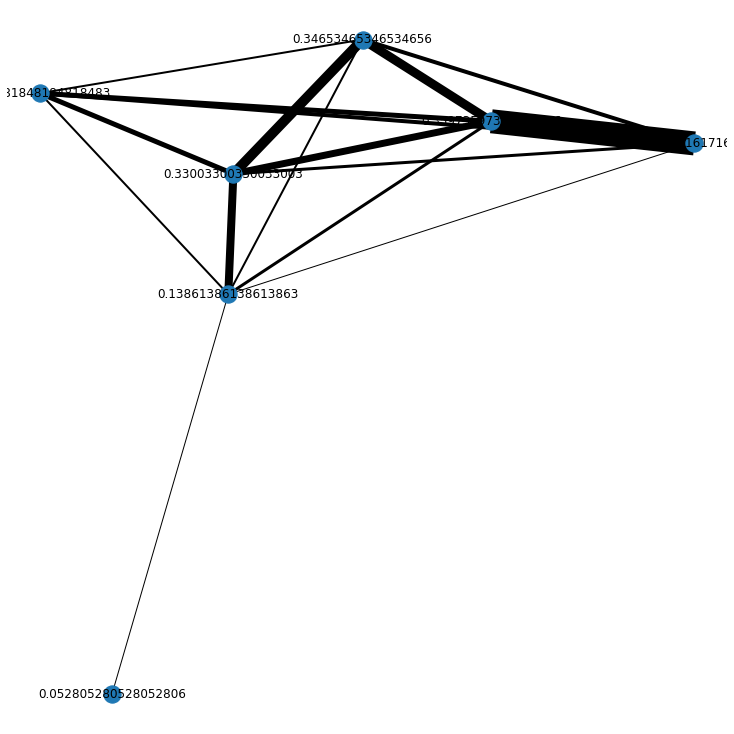

In [24]:
import matplotlib.pyplot as plt

def make_graph_for_visualization(text_id):
    plt.figure(figsize=(10, 10))
    G = graph_list[text_id]
        
    top5 = get_top5(text_id)
    subgraph_edges = [(u, v) for u, v in G.edges if u in top5 or v in top5]
        
    H = G.subgraph(top5)
    
    pos = nx.spring_layout(H)
    edges = H.edges()
    weights = [H[u][v]["weight"] for u, v in edges]
    
    labels = {key: degrees[text_id][key] for key in H.nodes}
                   
    nx.draw(H, pos, width=weights, labels=labels, with_labels=True)
    
make_graph_for_visualization(4)

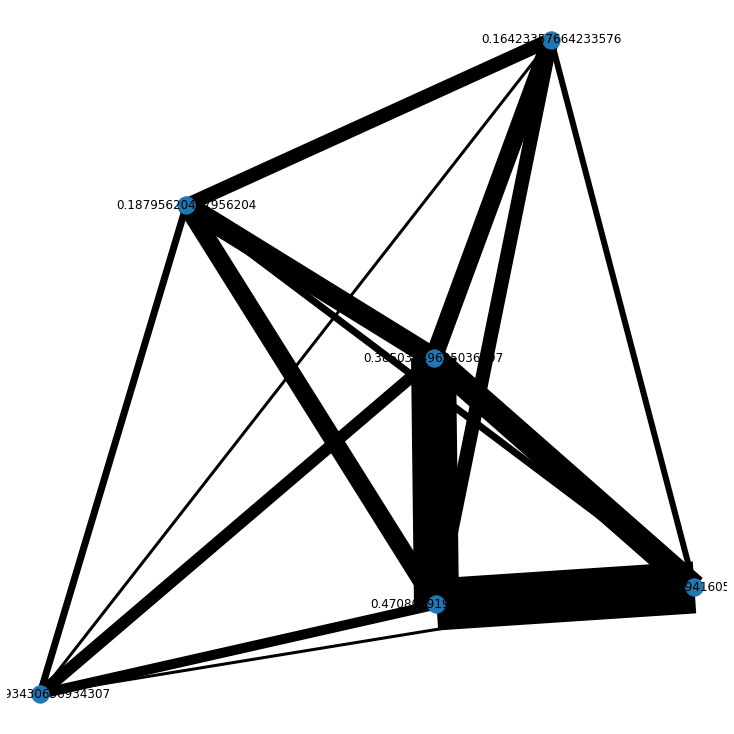

In [25]:
make_graph_for_visualization(12)

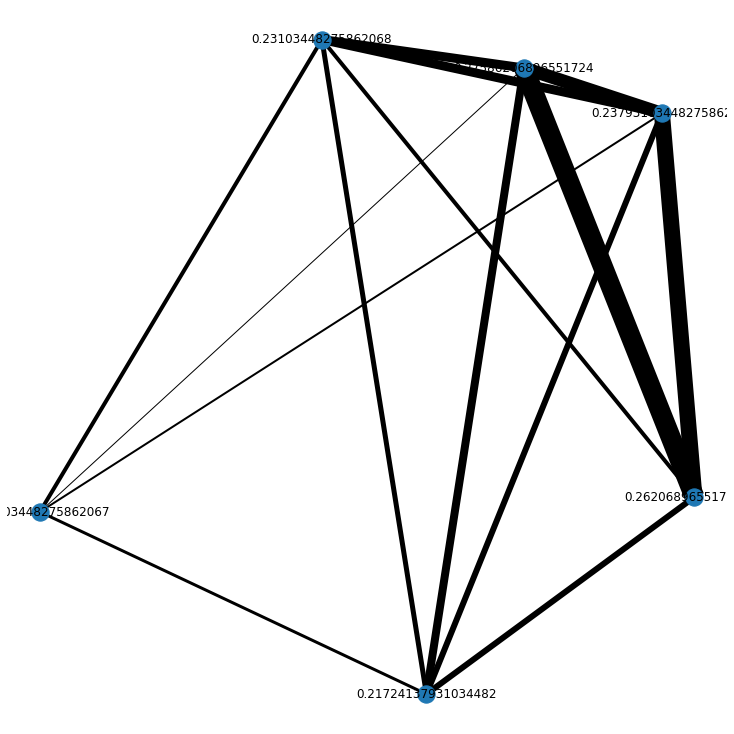

In [26]:
make_graph_for_visualization(14)